# An Analysis of Yield Tokenization and Arbitrage Opportunities for Liquid Restaking Tokens on Pendle

- What are the drivers of the fixed yields? Is there a correlation between yields and the token price in which the reward are being distributed?
- How correlated are each LRTs between each other?
- How are the various tenors correlated?
- Is there also a liquidity factor: i,e llliquid pools outperform? Why do some LRT offer more yield than others because that should not exist?
- Are there any possible arbitrage strategies that can be created?

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import prepare_data, prepare_data_single
from datetime import datetime, timedelta
import plotly.graph_objects as go

sns.set_style('whitegrid')

# Expiry (maturity) and start dates
expiry_date_jun = datetime(2024, 6, 27) # 27th June 2024
start_date_jun = datetime(2024, 4, 14) # 14th April 2024

expiry_date_sep = datetime(2024, 9, 26) # 26th September 2024
start_date_sep = datetime(2024, 5, 14) # 14th May 2024

expiry_date_dec = datetime(2024, 12, 26) # 26th December 2024
start_date_dec = datetime(2024, 4, 14) # 14th April 2024

# etherfi wETH file paths
underlying_path = 'data/etherfi_wETH_ohlcv_data.csv'
pt_jun_path = 'data/etherfi_wEth_Jun_pt_ohlcv_data.csv'
yt_jun_path = 'data/etherfi_wEth_Jun_yt_ohlcv_data.csv'
pt_sep_path = 'data/etherfi_wEth_Sep_pt_ohlcv_data.csv'
yt_sep_path = 'data/etherfi_wEth_Sep_yt_ohlcv_data.csv'
pt_dec_path = 'data/etherfi_wEth_Dec_pt_ohlcv_data.csv'
yt_dec_path = 'data/etherfi_wEth_Dec_yt_ohlcv_data.csv'
tvl_path = 'data/etherfi_wETH_tvl_data.csv'

prices_df_jun = prepare_data('data/etherfi_wETH_ohlcv_data.csv', 'data/etherfi_wEth_Jun_pt_ohlcv_data.csv', 'data/etherfi_wEth_Jun_yt_ohlcv_data.csv')
prices_df_sep = prepare_data('data/etherfi_wETH_ohlcv_data.csv', 'data/etherfi_wEth_Sep_pt_ohlcv_data.csv', 'data/etherfi_wEth_Sep_yt_ohlcv_data.csv')
prices_df_dec = prepare_data('data/etherfi_wETH_ohlcv_data.csv', 'data/etherfi_wEth_Dec_pt_ohlcv_data.csv', 'data/etherfi_wEth_Dec_yt_ohlcv_data.csv')

tvl_data = prepare_data_single('data/etherfi_wEth_tvl_data.csv')

# Merge TVL data with each dataframe
prices_df_jun = prices_df_jun.join(tvl_data, how='inner', rsuffix='_tvl')
prices_df_sep = prices_df_sep.join(tvl_data, how='inner', rsuffix='_tvl')
prices_df_dec = prices_df_dec.join(tvl_data, how='inner', rsuffix='_tvl')

# Rename TVL column for clarity
prices_df_jun.rename(columns={'open_tvl': 'tvl'}, inplace=True)
prices_df_sep.rename(columns={'open_tvl': 'tvl'}, inplace=True)
prices_df_dec.rename(columns={'open_tvl': 'tvl'}, inplace=True)

# Truncate at start date
prices_df_jun = prices_df_jun[prices_df_jun.index >= start_date_jun]
prices_df_sep = prices_df_sep[prices_df_sep.index >= start_date_sep]
prices_df_dec = prices_df_dec[prices_df_dec.index >= start_date_dec]

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from utils import prepare_data

sns.set_style('whitegrid')

def calculate_implied_apy(prices_df, expiry_date):
    # Calculate the remaining days to expiry
    prices_df['days_to_expiry'] = (expiry_date - prices_df.index).days

    # Convert PT and YT prices from USD to ETH using the underlying price
    prices_df['pt_open_eth'] = prices_df['pt_open'] / prices_df['underlying_open']
    prices_df['yt_open_eth'] = prices_df['yt_open'] / prices_df['underlying_open']

    # Calculate the implied APY using ETH prices
    prices_df['implied_apy_eth'] = (1 + prices_df['yt_open_eth'] / prices_df['pt_open_eth']) ** (365 / prices_df['days_to_expiry']) - 1
    prices_df['implied_apy_usd'] = (1 + prices_df['yt_open'] / prices_df['pt_open']) ** (365 / prices_df['days_to_expiry']) - 1

    return prices_df

# Calculate the implied APYs
prices_df_jun = calculate_implied_apy(prices_df_jun, expiry_date_jun)
prices_df_sep = calculate_implied_apy(prices_df_sep, expiry_date_sep)
prices_df_dec = calculate_implied_apy(prices_df_dec, expiry_date_dec)

# Combine dataframes
combined_df = pd.concat([prices_df_jun.assign(maturity='Jun'),
                         prices_df_sep.assign(maturity='Sep'),
                         prices_df_dec.assign(maturity='Dec'),],)

# Convert dates to ordinal for PCA
combined_df['date_ordinal'] = combined_df.index.map(datetime.toordinal)

combined_df


,pt_open,yt_open,underlying_open,tvl,days_to_expiry,pt_open_eth,yt_open_eth,implied_apy_eth,implied_apy_usd,maturity,date_ordinal
time,,,,,,,,,,,
2024-04-14,2817.0656,179.6897,3027.429932,3.281548e+09,74,0.930514,0.059354,0.356617,0.356617,Jun,738990
2024-04-15,2949.7946,208.5048,3159.802490,3.539216e+09,73,0.933538,0.065987,0.407044,0.407044,Jun,738991
2024-04-16,2900.7174,195.8079,3104.504639,3.524815e+09,72,0.934358,0.063072,0.392567,0.392567,Jun,738992
2024-04-17,2903.2954,176.8767,3089.008545,3.518701e+09,71,0.939879,0.057260,0.355302,0.355302,Jun,738993
2024-04-18,2810.2686,169.1899,2989.874268,3.419059e+09,70,0.939929,0.056588,0.356401,0.356401,Jun,738994
...,...,...,...,...,...,...,...,...,...,...,...
2024-06-04,3490.3478,272.7769,3770.321045,6.114568e+09,205,0.925743,0.072348,0.143368,0.143368,Dec,739041
2024-06-05,3565.8656,255.1665,3812.908936,6.377746e+09,204,0.935209,0.066922,0.131630,0.131630,Dec,739042
2024-06-06,3589.7621,269.4118,3859.197021,6.485312e+09,203,0.930184,0.069810,0.138963,0.138963,Dec,739043


In [30]:
# Create a line plot of implied APYs
fig = go.Figure()

fig.add_trace(go.Scatter(x=prices_df_jun.index, y=prices_df_jun['implied_apy_usd'], mode='lines', name='Jun'))
fig.add_trace(go.Scatter(x=prices_df_sep.index, y=prices_df_sep['implied_apy_usd'], mode='lines', name='Sep'))
fig.add_trace(go.Scatter(x=prices_df_dec.index, y=prices_df_dec['implied_apy_usd'], mode='lines', name='Dec'))

# Set the title
fig.update_layout(title='Implied APYs (USD)')

# Show the plot
fig.show()

In [31]:
# Plot tvl
fig = go.Figure()

fig.add_trace(go.Scatter(x=prices_df_jun.index, y=prices_df_jun['tvl'], mode='lines', name='Jun', fill='tozeroy'))

# Set the title
fig.update_layout(title='TVL')

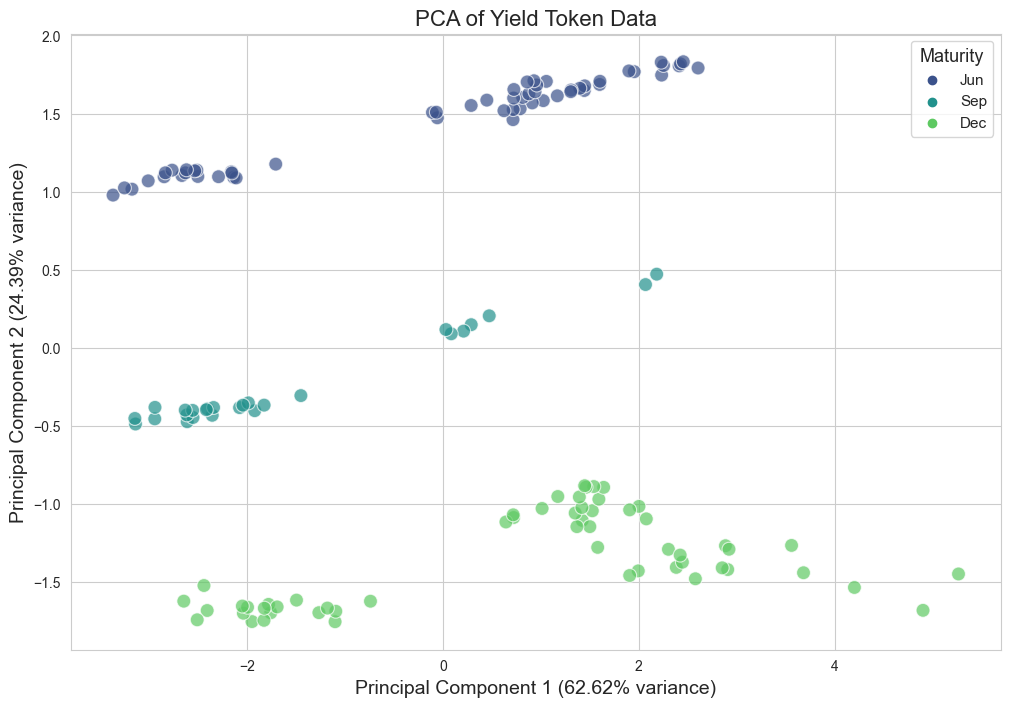

Explained variance ratio: [0.62621896 0.24392457]
                      PC1       PC2
pt_open         -0.459126  0.048197
yt_open          0.274954 -0.563529
underlying_open -0.419346 -0.165750
days_to_expiry   0.174396 -0.706887
implied_apy_usd  0.312466  0.338015
date_ordinal    -0.446448 -0.121787
tvl             -0.458680 -0.154475


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from datetime import datetime

# Assuming combined_df is already prepared with necessary columns

# Prepare data for PCA
features = ['pt_open', 'yt_open', 'underlying_open', 'days_to_expiry', 'implied_apy_usd', 'date_ordinal', 'tvl']
x = combined_df[features].values
x = StandardScaler().fit_transform(x)

# Perform PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
combined_df['pca1'] = principalComponents[:, 0]
combined_df['pca2'] = principalComponents[:, 1]

# Get explained variance ratios
explained_variance_ratio = pca.explained_variance_ratio_

# Plot PCA results
plt.figure(figsize=(12, 8))
pca_plot = sns.scatterplot(x='pca1', y='pca2', hue='maturity', data=combined_df, palette='viridis', s=100, alpha=0.7)

# # Add labels to the points
# for i in range(len(combined_df)):
#     pca_plot.text(combined_df['pca1'].iloc[i] + 0.02, combined_df['pca2'].iloc[i], combined_df.index[i].strftime('%Y-%m-%d'),
#                   horizontalalignment='left', size='small', color='black', alpha=0.7)

# Enhance the plot
plt.title('PCA of Yield Token Data', fontsize=16)
plt.xlabel(f'Principal Component 1 ({explained_variance_ratio[0]*100:.2f}% variance)', fontsize=14)
plt.ylabel(f'Principal Component 2 ({explained_variance_ratio[1]*100:.2f}% variance)', fontsize=14)
plt.legend(title='Maturity', title_fontsize='13', fontsize='11', loc='upper right')
plt.grid(True)
plt.show()

# Explain variance
print("Explained variance ratio:", explained_variance_ratio)

# Get the loadings (coefficients) of each feature for the principal components
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=features)
print(loadings)


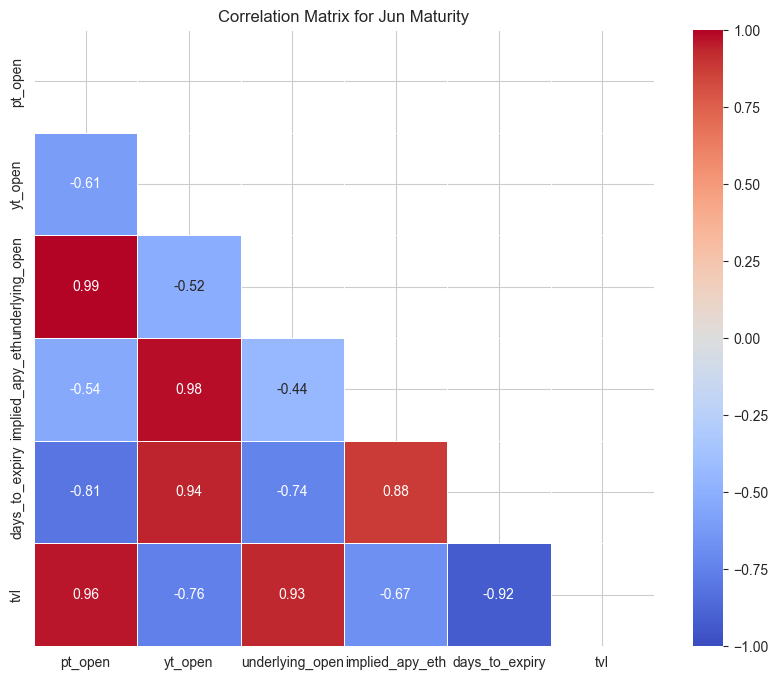

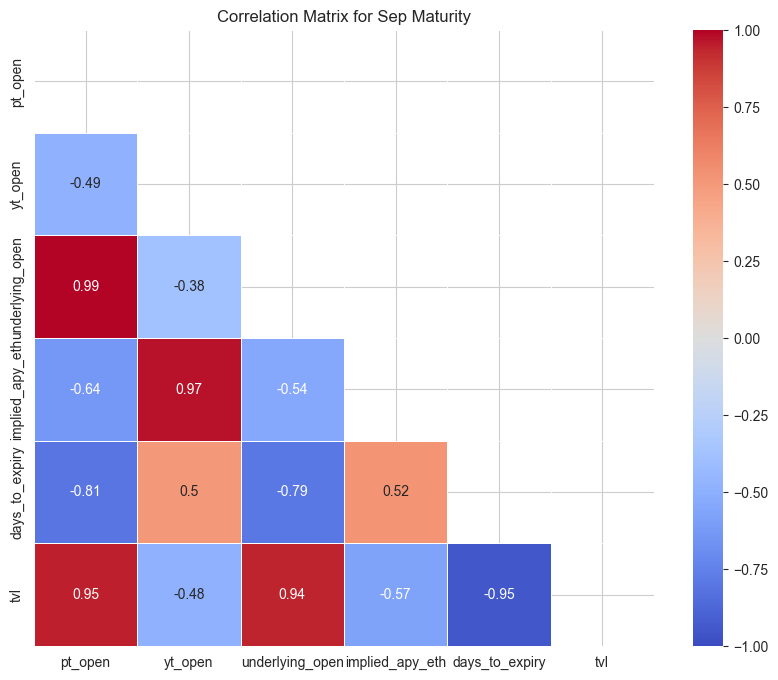

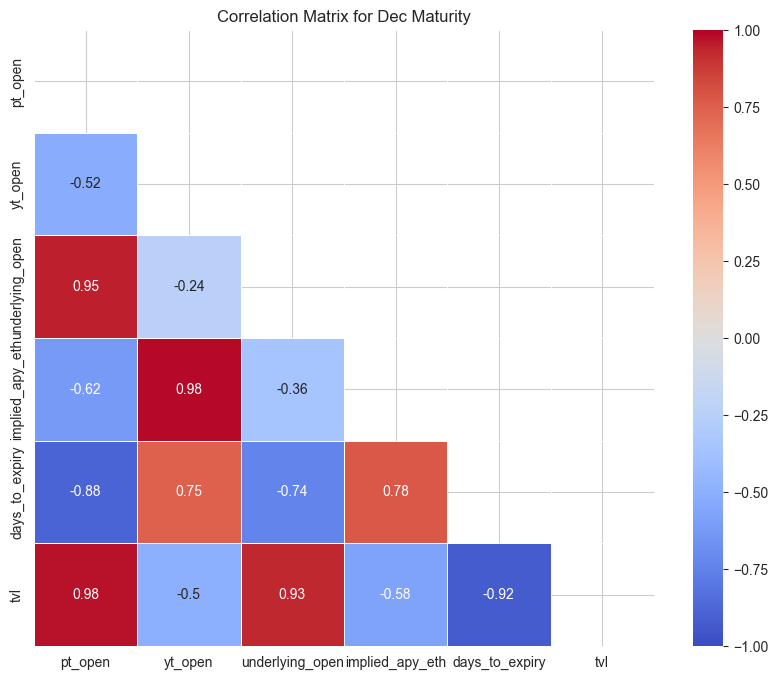

In [33]:
import numpy as np

# Function to plot lower triangular correlation matrix
def plot_lower_triangular_correlation_matrix(data, title):
    correlation_matrix = data.corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=.5)
    plt.title(title)
    plt.show()

# Calculate and plot lower triangular correlation matrix for Jun maturity
plot_lower_triangular_correlation_matrix(prices_df_jun[['pt_open', 'yt_open', 'underlying_open', 'implied_apy_eth', 'days_to_expiry', 'tvl']], 'Correlation Matrix for Jun Maturity')

# Calculate and plot lower triangular correlation matrix for Sep maturity
plot_lower_triangular_correlation_matrix(prices_df_sep[['pt_open', 'yt_open', 'underlying_open', 'implied_apy_eth', 'days_to_expiry', 'tvl']], 'Correlation Matrix for Sep Maturity')

# Calculate and plot lower triangular correlation matrix for Dec maturity
plot_lower_triangular_correlation_matrix(prices_df_dec[['pt_open', 'yt_open', 'underlying_open', 'implied_apy_eth', 'days_to_expiry', 'tvl']], 'Correlation Matrix for Dec Maturity')



                 implied_apy_jun  implied_apy_sep  implied_apy_dec
implied_apy_jun         1.000000         0.493010         0.483513
implied_apy_sep         0.493010         1.000000         0.284172
implied_apy_dec         0.483513         0.284172         1.000000


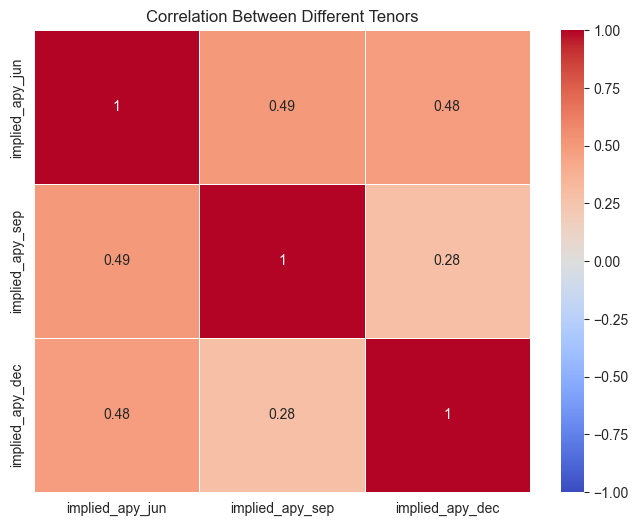

In [37]:
# Create a dataframe with implied APYs for different maturities
apy_df = pd.DataFrame({
    'implied_apy_jun': prices_df_jun['implied_apy_usd'],
    'implied_apy_sep': prices_df_sep['implied_apy_usd'],
    'implied_apy_dec': prices_df_dec['implied_apy_usd']
}).dropna()

# Calculate pairwise correlations
tenor_correlations = apy_df.corr()
print(tenor_correlations)

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(tenor_correlations, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=.5)
plt.title('Correlation Between Different Tenors')
plt.show()


c:\Python310\lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



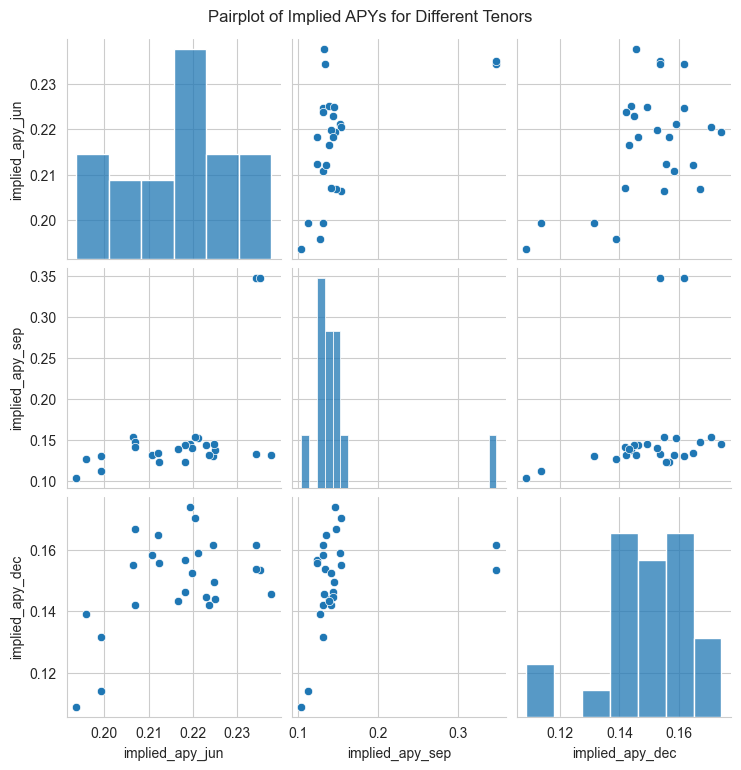

In [38]:
# Pairplot to visualize relationships
sns.pairplot(apy_df)
plt.suptitle('Pairplot of Implied APYs for Different Tenors', y=1.02)
plt.show()
